In [1]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [2]:
from transpile_benchy.interfaces.qiskit_interface import (
    # QiskitCircuitInterface,
    QuantumCircuitFactory,
)
from qiskit.circuit.library import TwoLocal

num_qubits = [8, 16, 24, 32]


def full(n):
    return TwoLocal(n, "ry", "cz", entanglement="full", reps=3)


def linear(n):
    return TwoLocal(n, "ry", "cz", entanglement="linear", reps=3)

In [3]:
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary.from_submodules(
    [
        QuantumCircuitFactory(full, num_qubits),
        # QuantumCircuitFactory(linear_two_local, num_qubits),
    ]
)

In [4]:
from transpile_benchy.passmanagers.qiskit_baseline import QiskitBaseline
from qiskit.transpiler import CouplingMap
from quantum_logical.coupling_util import CorralCoupling, TreeCoupling

heavy_hex = CouplingMap.from_heavy_hex(5)
square_lattice = CouplingMap.from_grid(7, 7)
corral = CorralCoupling(16)
tree = TreeCoupling(4, 4)

baseline_sq = QiskitBaseline(optimization_level=3, coupling_map=square_lattice)
baseline_hh = QiskitBaseline(optimization_level=3, coupling_map=heavy_hex)
baseline_corral = QiskitBaseline(optimization_level=3, coupling_map=corral)
baseline_tree = QiskitBaseline(optimization_level=3, coupling_map=tree)

# FIXME, we don't have a way of distinguishing between these transpilers w/o a name
baseline_sq.name = "square_lattice"
baseline_hh.name = "heavy_hex"
baseline_corral.name = "corral"
baseline_tree.name = "tree"

transpilers = [baseline_sq, baseline_hh, baseline_corral, baseline_tree]

In [5]:
from transpile_benchy.metrics.abc_metrics import MetricInterface
from qiskit.transpiler.basepasses import AnalysisPass
from monodromy.coverage import convert_gate_to_monodromy_coordinate
import numpy as np
from transpile_benchy.metrics.abc_metrics import DoNothing


class CombinedMetricsPass(AnalysisPass):
    """Combined pass for calculating CCR, Mean Qubit Hotspotness, and Temporal Burstiness."""

    def __init__(self):
        super().__init__()

    def run(self, dag):
        # Initialize counters and storage
        num_swap = 0
        num_computation = 0
        swap_counts = {q: 0 for q in dag.qubits}
        layer_swap_counts = []

        for layer_i, layer in enumerate(dag.layers()):
            layer_swap_counts.append(0)
            for gate_node in layer["graph"].two_qubit_ops():
                t_c = convert_gate_to_monodromy_coordinate(gate_node.op)
                if np.allclose(t_c, [0.25, 0.25, 0.25, -0.75]):
                    num_swap += 1
                    layer_swap_counts[layer_i] += 1
                    for q in gate_node.qargs:
                        swap_counts[q] += 1
                else:
                    num_computation += 1

        # Calculate metrics
        ccr = num_swap / num_computation if num_computation != 0 else 0
        mean_swap = np.mean(list(swap_counts.values()))
        variance_swap = np.var(list(swap_counts.values()))
        mean_qubit_hotspotness = variance_swap / mean_swap if mean_swap != 0 else 0
        layer_mean_swap = np.mean(layer_swap_counts)
        layer_variance_swap = np.var(layer_swap_counts)
        temporal_burstiness = (
            layer_variance_swap / layer_mean_swap if layer_mean_swap != 0 else 0
        )

        # Store metrics in the property set
        self.property_set["ccr"] = ccr
        self.property_set["mean_qubit_hotspotness"] = mean_qubit_hotspotness
        self.property_set["temporal_burstiness"] = temporal_burstiness


class CCR(MetricInterface):
    """CCR metric utilizing the CombinedMetricsPass for computation."""

    def __init__(self):
        super().__init__(name="ccr", pretty_name="CCR")

    def _construct_pass(self):
        return CombinedMetricsPass()


class MeanQubitHotspotness(MetricInterface):
    """Mean Qubit Hotspotness metric that extracts its value after CombinedMetricsPass has run."""

    def __init__(self):
        super().__init__(
            name="mean_qubit_hotspotness", pretty_name="Mean Qubit Hotspotness"
        )

    def _construct_pass(self):
        # This metric relies on the property set filled by the CombinedMetricsPass
        return DoNothing()


class TemporalBurstiness(MetricInterface):
    """Temporal Burstiness metric that extracts its value after CombinedMetricsPass has run."""

    def __init__(self):
        super().__init__(name="temporal_burstiness", pretty_name="Temporal Burstiness")

    def _construct_pass(self):
        # This metric relies on the property set filled by the CombinedMetricsPass
        return DoNothing()

In [6]:
from transpile_benchy.metrics.gate_counts import DepthMetric, TotalMetric
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks

depth_metric = DepthMetric(consolidate=True)
total_metric = TotalMetric(consolidate=True)

ccr_metric = CCR()
mean_qubit_hotspotness_metric = MeanQubitHotspotness()
temporal_burstiness_metric = TemporalBurstiness()

metrics = [
    depth_metric,
    total_metric,
    ccr_metric,
    mean_qubit_hotspotness_metric,
    temporal_burstiness_metric,
]

requires = [Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)]

for transpiler in transpilers:
    transpiler._append_metric_dependencies(requires)

In [7]:
benchmark = Benchmark(
    transpilers=transpilers,
    metrics=metrics,
    circuit_library=lib,
    logger=transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...


Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx


Circuits from library:   0%|          | 0/4 [00:00<?, ?it/s]INFO:transpile_benchy:Running benchmark for circuit full_n8


Loading full_n8 from QuantumCircuitFactory


Circuits from library:  25%|██▌       | 1/4 [00:03<00:09,  3.06s/it]INFO:transpile_benchy:Running benchmark for circuit full_n16


Loading full_n16 from QuantumCircuitFactory


Circuits from library:  50%|█████     | 2/4 [00:19<00:21, 10.74s/it]INFO:transpile_benchy:Running benchmark for circuit full_n24


Loading full_n24 from QuantumCircuitFactory


Circuits from library:  75%|███████▌  | 3/4 [00:56<00:22, 23.00s/it]INFO:transpile_benchy:Running benchmark for circuit full_n32


Loading full_n32 from QuantumCircuitFactory


Circuits from library: 100%|██████████| 4/4 [01:52<00:00, 28.23s/it]


In [14]:
# print(benchmark)

In [15]:
# benchmark.summary_statistics(baseline_sq, baseline_hh)

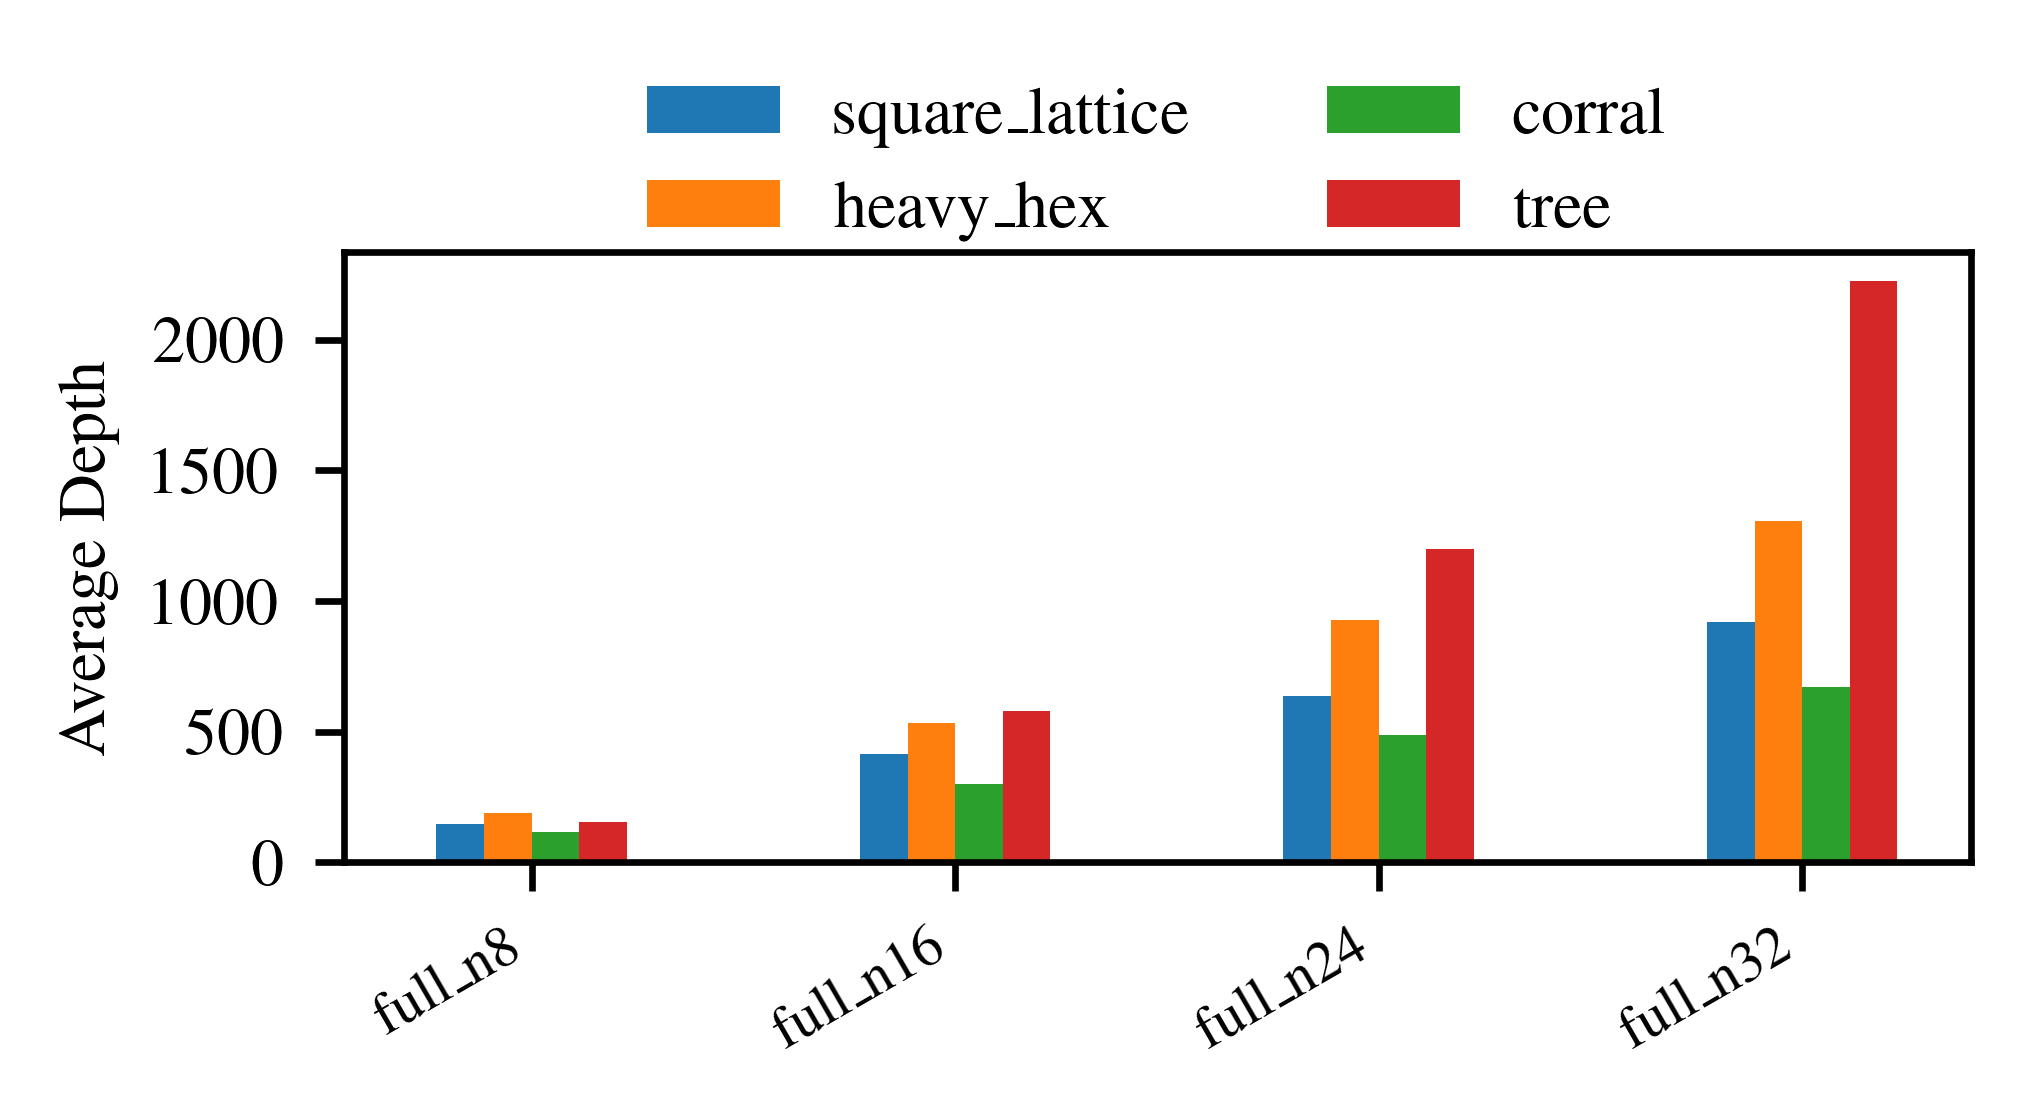

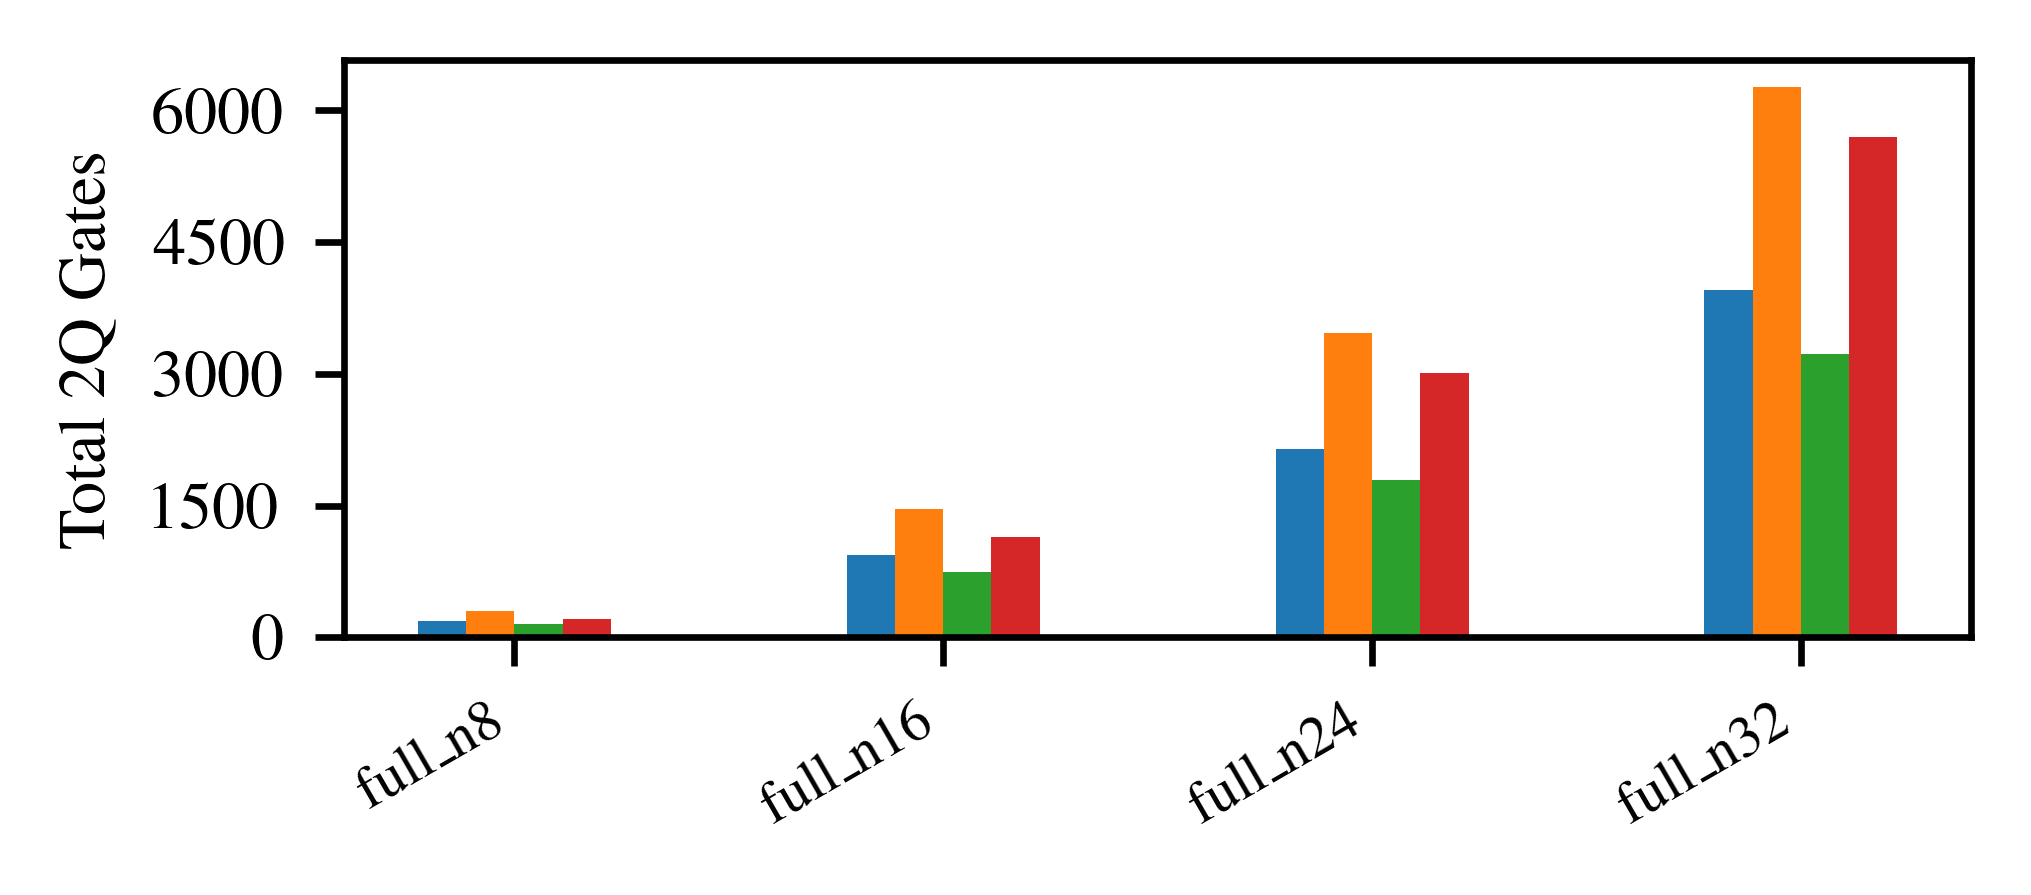

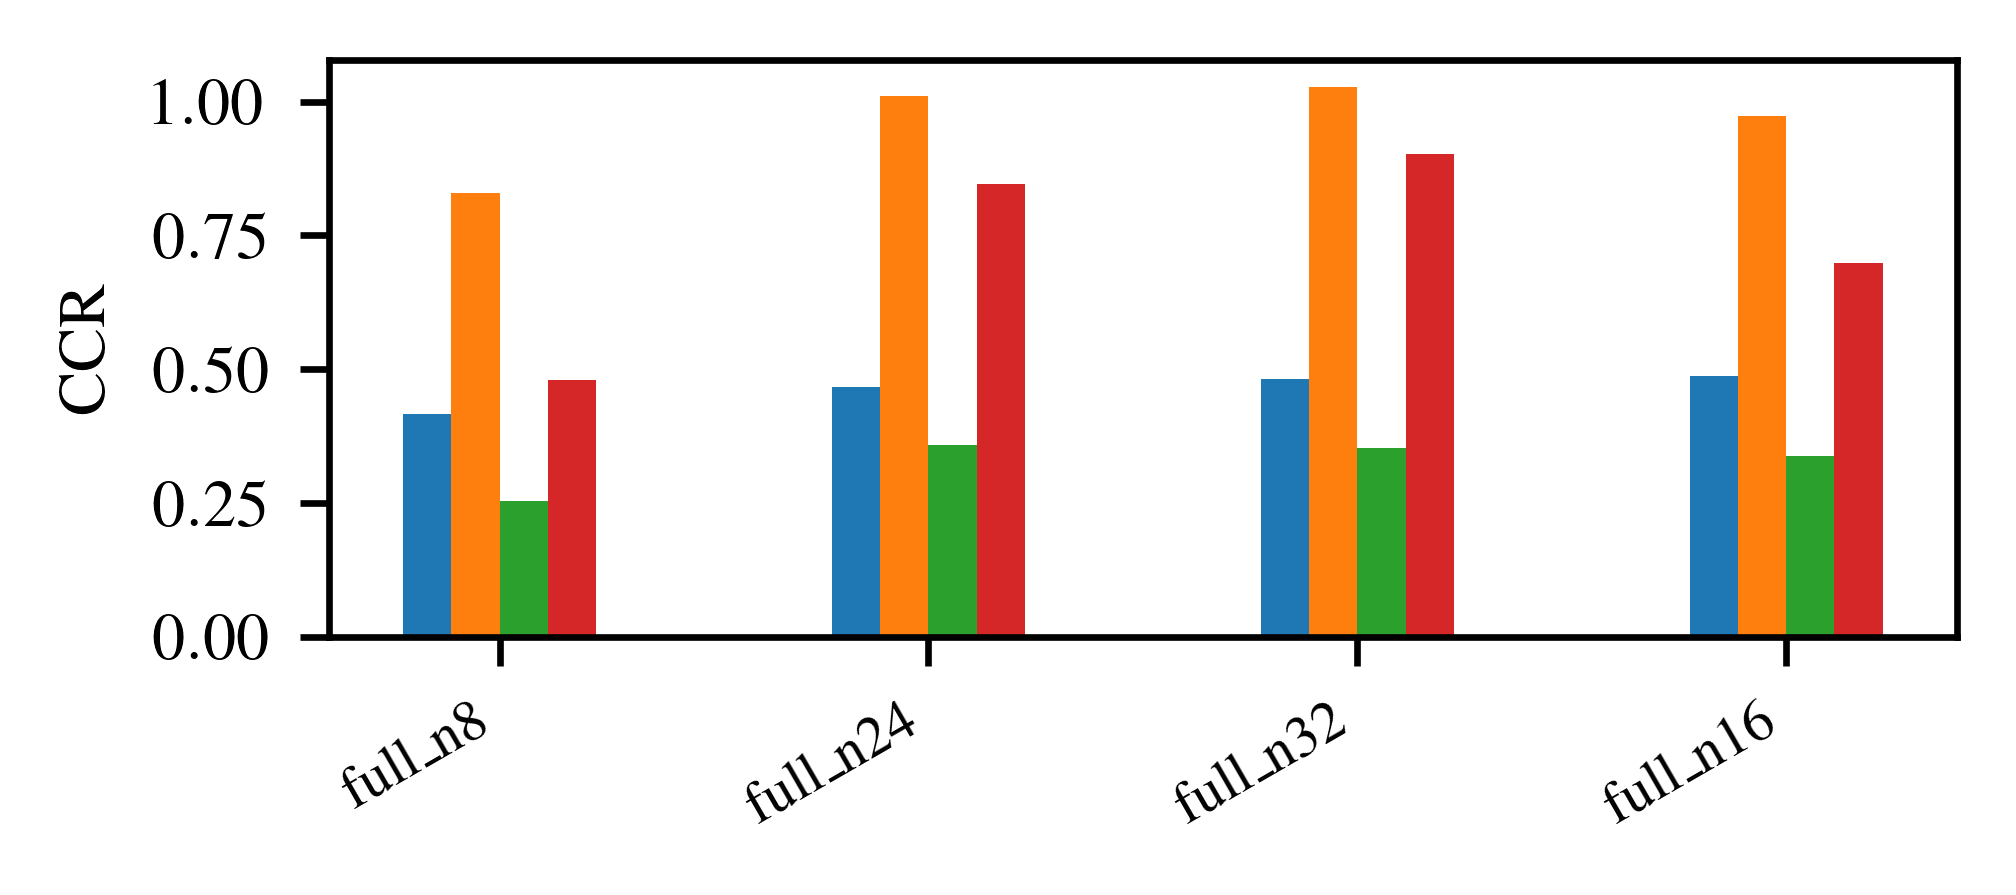

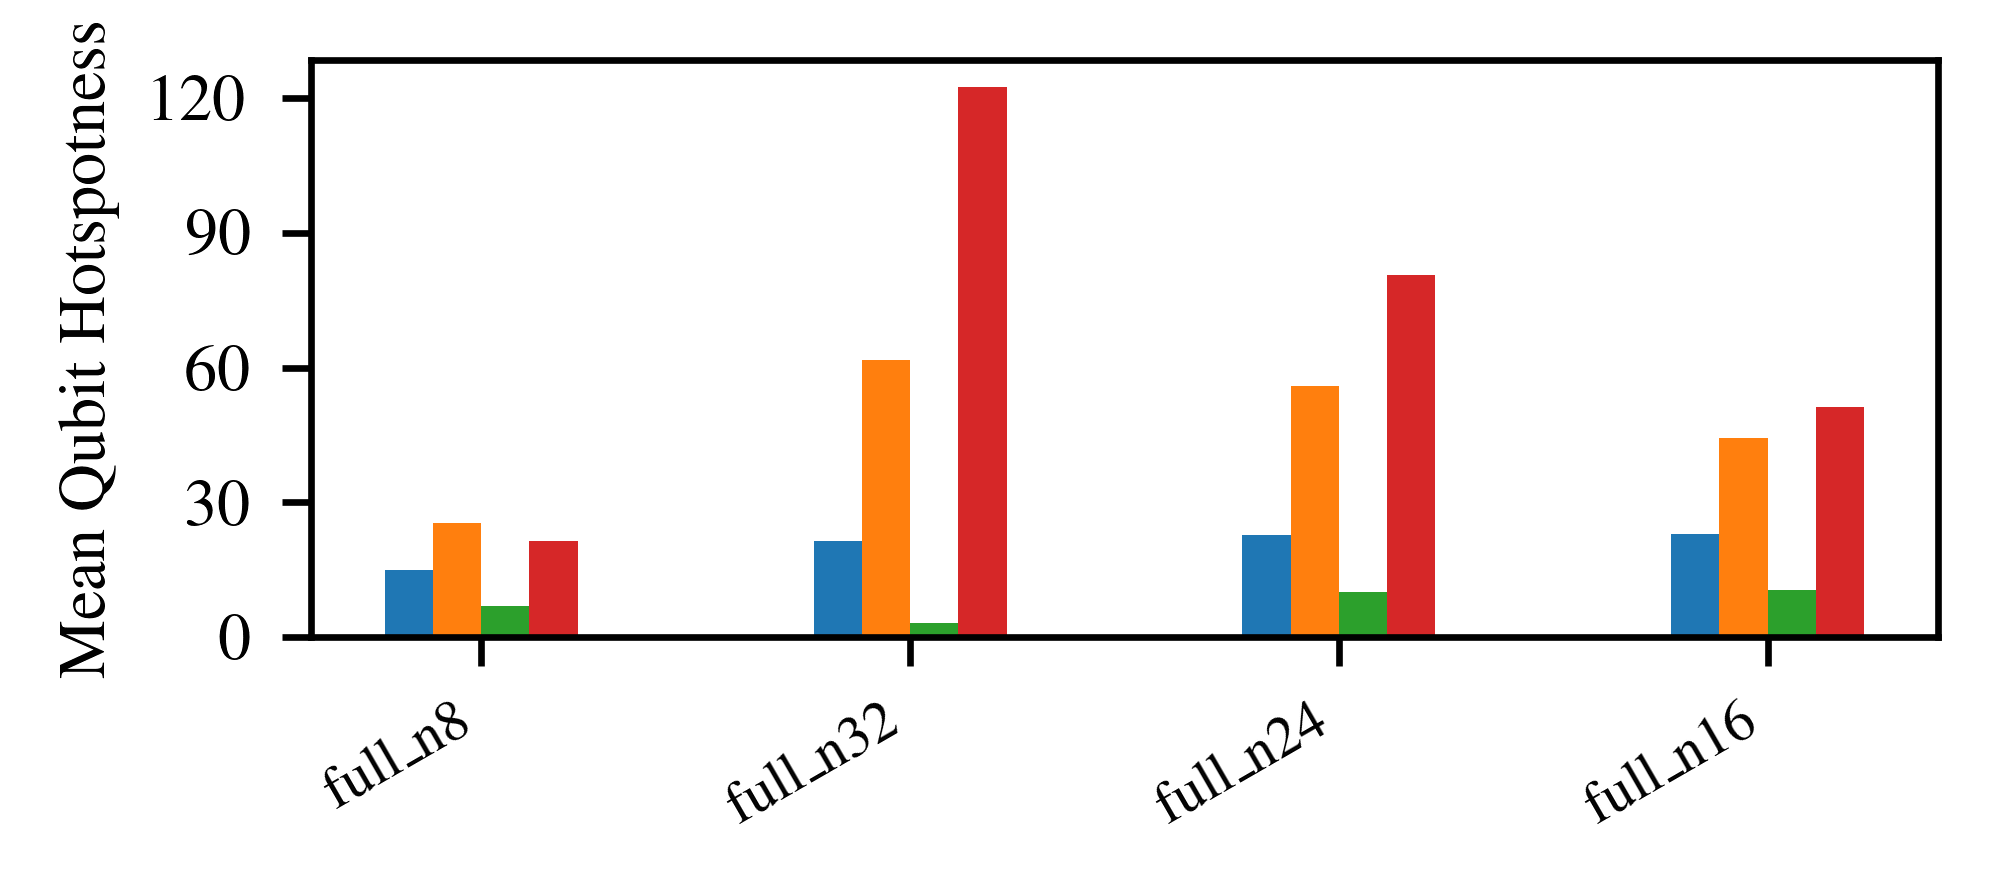

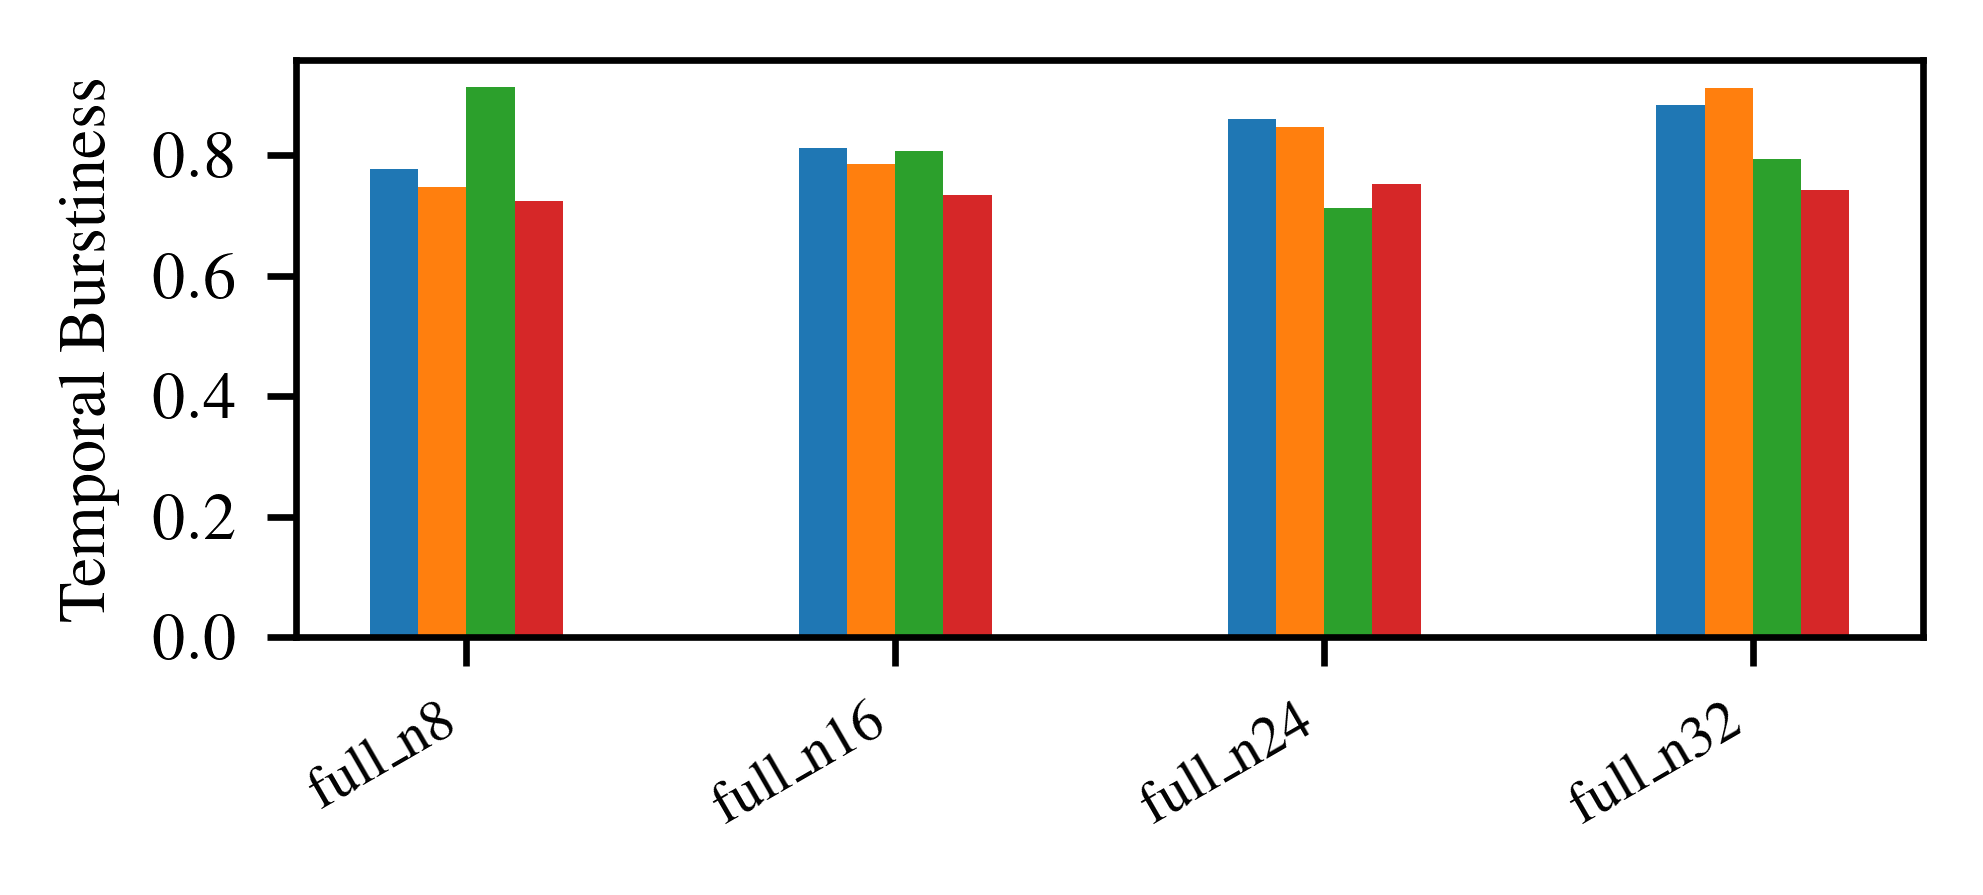

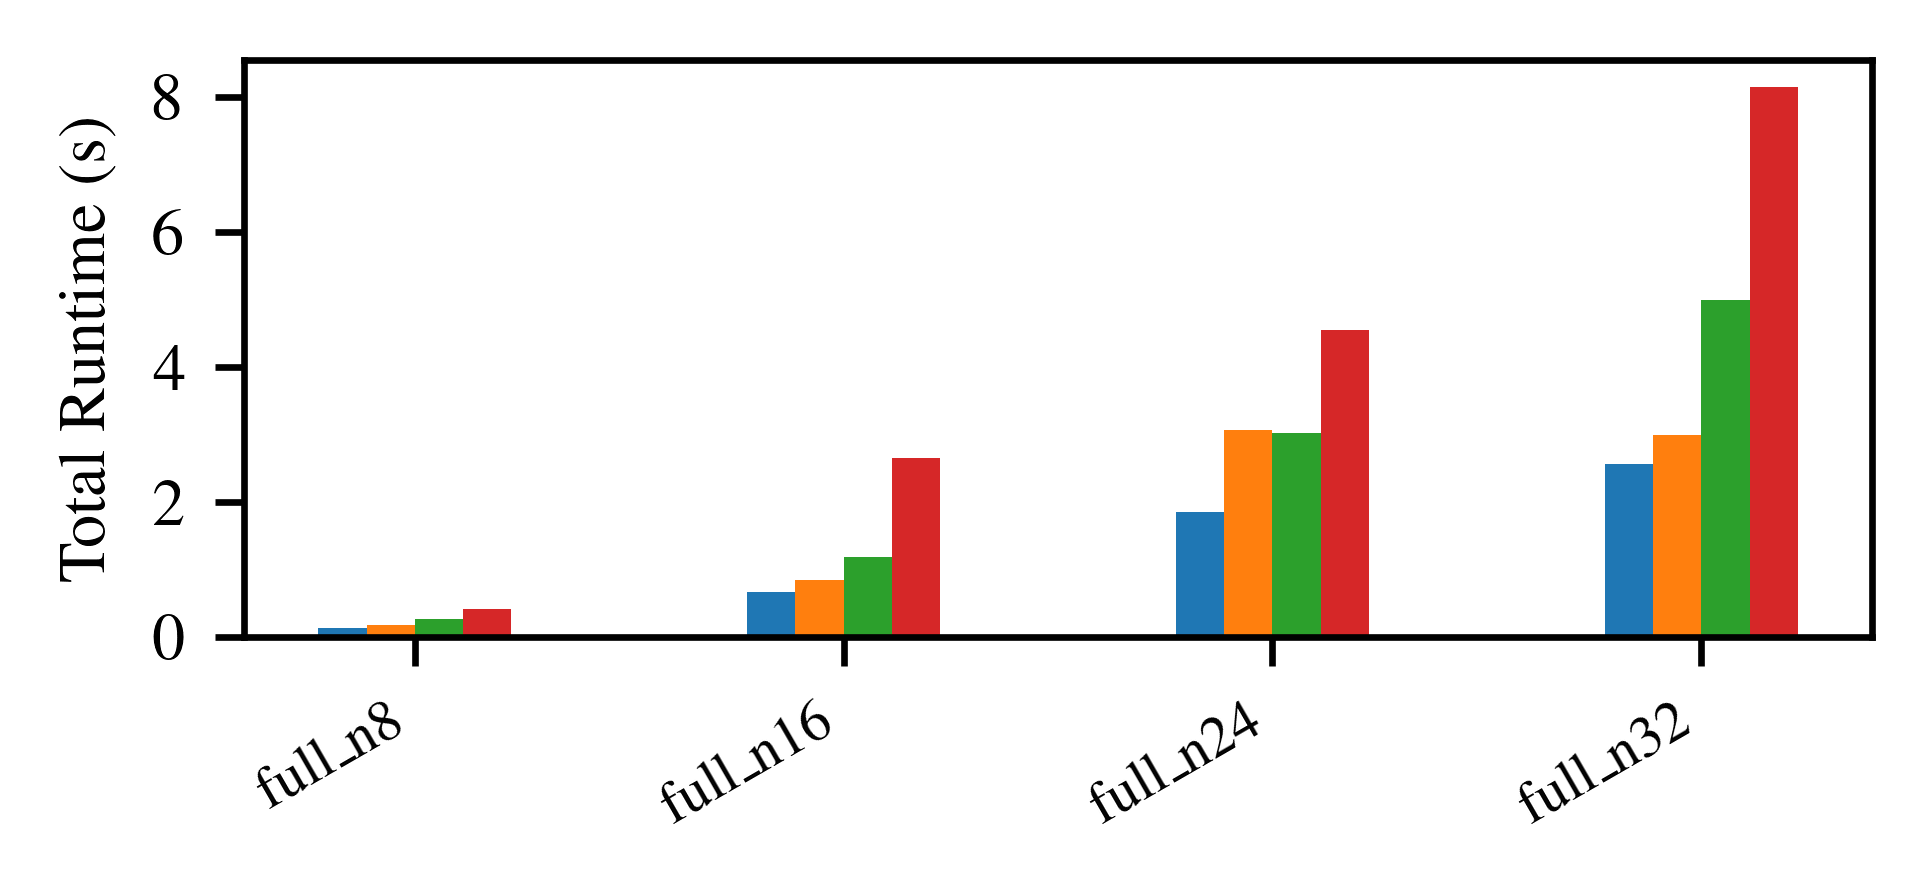

In [13]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(benchmark, save=0, legend_show=1)